In [1]:
import numpy as np
import pandas as pd
import learning_utils
from data_utils import DeepFakeDF, DeepFakeJPGDataset, DeepFakeDetectionDataset
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import fastai
import fastai.vision

# Requirements

Data format:
* Faces and STFTs must have been extracted with the script extract_face_sound.py.
* In each video folder ('train_sample_videos', 'dfdc_train_videos_X', ...'), there must be folders of faces and stfts for each video.

#### Data indexing

In [2]:
df = DeepFakeDF(["train_sample_videos/"]).get_df()
# Dataset format - indexed on frames, simple use case where predictions 
# are made independently on each frame
df.head()

,audio,video_name,sample,label,actor_0,actor_1,dir
0,train_sample_videos/aagfhgtpmv/audio_0.jpg,aagfhgtpmv,0,FAKE,train_sample_videos/aagfhgtpmv/webcam_0_0.jpg,train_sample_videos/aagfhgtpmv/webcam_0_0.jpg,train_sample_videos
1,train_sample_videos/aagfhgtpmv/audio_1.jpg,aagfhgtpmv,1,FAKE,train_sample_videos/aagfhgtpmv/webcam_1_0.jpg,train_sample_videos/aagfhgtpmv/webcam_1_0.jpg,train_sample_videos
199,train_sample_videos/aagfhgtpmv/audio_2.jpg,aagfhgtpmv,2,FAKE,train_sample_videos/aagfhgtpmv/webcam_2_0.jpg,train_sample_videos/aagfhgtpmv/webcam_2_0.jpg,train_sample_videos
287,train_sample_videos/aagfhgtpmv/audio_3.jpg,aagfhgtpmv,3,FAKE,train_sample_videos/aagfhgtpmv/webcam_3_0.jpg,train_sample_videos/aagfhgtpmv/webcam_3_0.jpg,train_sample_videos
298,train_sample_videos/aagfhgtpmv/audio_4.jpg,aagfhgtpmv,4,FAKE,train_sample_videos/aagfhgtpmv/webcam_4_0.jpg,train_sample_videos/aagfhgtpmv/webcam_4_0.jpg,train_sample_videos


In [3]:
# Dataset format - indexed on videos, use case where all the frames of a 
# video are used to make a TRUE/FAKE prediction.
# Each video is assigned a list of all its extracted faces and all stfts.
gb = df.groupby('video_name')
audio = gb['audio'].apply(list)
video = gb['actor_0'].apply(list)
label = gb['label'].nth(0)
df = pd.concat([audio,video,label],axis=1)
df.reset_index(inplace = True)
df.head()

,video_name,audio,actor_0,label
0,aagfhgtpmv,"[train_sample_videos/aagfhgtpmv/audio_0.jpg, t...",[train_sample_videos/aagfhgtpmv/webcam_0_0.jpg...,FAKE
1,aapnvogymq,"[train_sample_videos/aapnvogymq/audio_0.jpg, t...",[train_sample_videos/aapnvogymq/webcam_0_0.jpg...,FAKE
2,abarnvbtwb,"[train_sample_videos/abarnvbtwb/audio_0.jpg, t...",[train_sample_videos/abarnvbtwb/webcam_0_0.jpg...,REAL
3,abofeumbvv,"[train_sample_videos/abofeumbvv/audio_0.jpg, t...",[train_sample_videos/abofeumbvv/webcam_0_0.jpg...,FAKE
4,abqwwspghj,"[train_sample_videos/abqwwspghj/audio_0.jpg, t...",[train_sample_videos/abqwwspghj/webcam_0_0.jpg...,FAKE


In [4]:
"""test_df = DeepFakeDF(["test_videos/"], test = True).get_df()

gb = test_df.groupby('video_name')
audio = gb['audio'].apply(list)
video = gb['actor_0'].apply(list)
label = gb['label'].nth(0)
test_df = pd.concat([audio,video,label],axis=1)
test_df.reset_index(inplace = True)"""

'test_df = DeepFakeDF(["test_videos/"], test = True).get_df()\n\ngb = test_df.groupby(\'video_name\')\naudio = gb[\'audio\'].apply(list)\nvideo = gb[\'actor_0\'].apply(list)\nlabel = gb[\'label\'].nth(0)\ntest_df = pd.concat([audio,video,label],axis=1)\ntest_df.reset_index(inplace = True)'

In [5]:
# train/val split indices
val_perc = 0.2
n_val = int(val_perc*len(df))
shuffled_idx = np.random.permutation(df.index.tolist())

val_idx = shuffled_idx[:n_val]
train_idx = shuffled_idx[n_val:]

#### torch dataset creation

In [6]:
downsample_factor = 10 # using one every 10 frames only
n_frames = 300 // downsample_factor

# train/val torch datasets & dataloaders
tr_images = DeepFakeJPGDataset(df.iloc[train_idx].reset_index(drop = True), 
                               'actor_0', transforms.Resize((150,100)), downsample_factor)
tr_sound = DeepFakeJPGDataset(df.iloc[train_idx].reset_index(drop = True),
                               'audio', transforms.Resize((65,25)), downsample_factor)
train_ds = DeepFakeDetectionDataset(tr_images, tr_sound, tr_images.y)
train_dl = DataLoader(train_ds)

val_images = DeepFakeJPGDataset(df.iloc[val_idx].reset_index(drop = True), 
                                'actor_0', transforms.Resize((150,100)), downsample_factor)
val_sound = DeepFakeJPGDataset(df.iloc[val_idx].reset_index(drop = True), 
                               'audio', transforms.Resize((65,25)), downsample_factor)
valid_ds = DeepFakeDetectionDataset(val_images, val_sound, val_images.y)
valid_dl = DataLoader(valid_ds)

"""te_images = DeepFakeJPGDataset(test_df.reset_index(drop = True), 
                               'actor_0', transforms.Resize((150,100)), downsample_factor)
te_sound = DeepFakeJPGDataset(test_df.reset_index(drop = True),
                               'audio', transforms.Resize((65,25)), downsample_factor)
test_ds = DeepFakeDetectionDataset(te_images, te_sound, te_images.y)
test_dl = DataLoader(test_ds)"""

# fastai databunch
db = fastai.basic_data.DataBunch(train_dl,valid_dl) # test_dl
db.batch_size = 16

In [8]:
db.batch_size = 8

#### Models code

In [9]:
# Submodels
model_faces = fastai.vision.learner.create_body(fastai.vision.models.resnet18)

model_stfts = fastai.vision.learner.simple_cnn(actns = [1,8,16,32,64],
                                               strides = [(2,1),(2,2),(2,2),(1,1)],
                                               bn = True)

frame_embedding_size = 32
merge_layers = [512 + 64, 100, frame_embedding_size]
model_frame = learning_utils.fully_connected(merge_layers, dropout = [0.1]*len(merge_layers))

model_video = learning_utils.VideoModel(frame_embedding_size, n_frames)
# Global model
model = learning_utils.DeepFakeDetector(model_faces, model_stfts, model_frame, 
                             model_video, n_frames = n_frames)


In [10]:
learn = fastai.basic_train.Learner(db, model, metrics = [fastai.metrics.accuracy])#.load('20_ep_51e-4')
learn.layer_groups = learn.model.layer_groups

# Freezing the weights of the face model, as it is pretrained on imagenet
learn.freeze_to(1)

In [8]:
(x1,x2), y = next(iter(db.train_dl))
x1 = x1.to('cuda')
x2 = x2.to('cuda')

In [9]:
model(x1,x2)

tensor([[-0.9431, -0.4933],
        [-0.9086, -0.5160],
        [-0.8805, -0.5354],
        [-1.0765, -0.4167],
        [-0.7944, -0.6012],
        [-0.8755, -0.5390],
        [-0.9220, -0.5071],
        [-0.9563, -0.4850]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [35]:
model_faces(x1[:,0,:,:]).shape

torch.Size([8, 512, 5, 4])

In [36]:
model_stfts(x2[:,0,:,:]).shape

torch.Size([8, 64])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


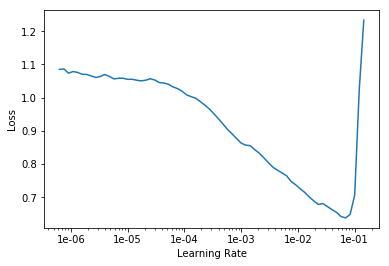

In [9]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(3,slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.548196,0.416910,0.850000,03:55
1,0.551842,0.450061,0.850000,03:53
2,0.489863,0.430119,0.850000,03:53


In [12]:
# Unfreezing resnet18's weights
learn.unfreeze()

In [13]:
learn.fit_one_cycle(10,slice(1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.435167,0.428654,0.850000,04:00
1,0.419490,0.446085,0.837500,03:59
2,0.384100,0.457663,0.800000,04:01
3,0.324473,0.439723,0.812500,04:00
4,0.261511,0.413720,0.825000,04:00
5,0.205530,0.400054,0.825000,04:00
6,0.164947,0.384535,0.825000,04:01
7,0.136579,0.381233,0.825000,04:00
8,0.118782,0.378387,0.825000,04:01
9,0.109283,0.379333,0.825000,04:00


In [12]:
learn.fit_one_cycle(10,5*1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.603848,0.540501,0.725000,01:23
1,0.405393,0.440084,0.812500,01:22
2,0.325628,0.435164,0.800000,01:22
3,0.304964,0.367607,0.862500,01:21
4,0.264422,0.386004,0.837500,01:22
5,0.207702,0.324583,0.862500,01:22
6,0.132341,0.315138,0.875000,01:22
7,0.074944,0.323226,0.875000,01:22
8,0.041357,0.328530,0.875000,01:22
9,0.025301,0.329194,0.875000,01:21


In [14]:
# For inference on the test set
learn.save('20_ep_51e-4')

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
pr = learn.get_preds()


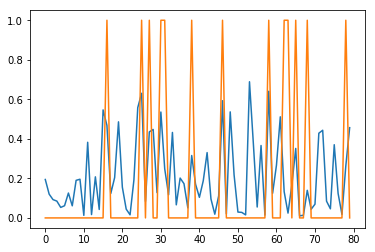

In [20]:
plt.plot(pr[0][:,1].numpy())
plt.plot(pr[1].numpy())

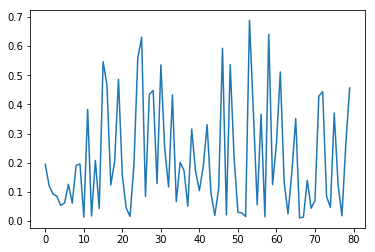

In [19]:
plt.plot(pr[0][:,1].numpy())